In [3]:
from dash import Dash, html, dash_table
import pandas as pd
import json
import requests
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import asyncio
from dash import Dash, html, dash_table, dcc
import datetime
import time
import pandas as pd
import os


c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
nasdaq = pd.read_html('Quotes For Nasdaq-100 Index _ Nasdaq.html')[0]

c:\Users\fabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\io\html.py:674: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(udoc, features="html5lib", from_encoding=from_encoding)


ValueError: No tables found

In [ ]:
# Função para prever o preço de uma ação


# Com dados de teste 80/20
# 100% reais, tentar prever 20% desses dados já obtidos, para avaliar a precisão do modelo
def forecast_prophet(ds, y):
    data = {'ds': ds, 'y': y}
    df = pd.DataFrame(data)
    
    # Dividindo os dados em 80/20
    split_index = int(len(df) * 0.8)
    train_data = df[:split_index]
    test_data = df[split_index:]
    
    # Instanciando o modelo Prophet
    model = Prophet()
    
    # Ajustando o modelo aos dados de treinamento
    model.fit(train_data)
    
    # Criando um dataframe com datas futuras para prever (20%)
    future = model.make_future_dataframe(periods=int(len(df) * 0.2))
    
    # Fazendo previsões
    forecast = model.predict(future)

    
    return forecast


# Sem dados de teste 80/20 
# 80% reais e 20% futuros
def forecast_prophet(ds, y):
    data = {'ds': ds, 'y': y}
    df = pd.DataFrame(data)
    
    # Instanciando o modelo Prophet
    model = Prophet()
    # Ajustando o modelo aos dados de treinamento
    model.fit(df)

    # Criando um dataframe com datas futuras para prever (20%)
    future = model.make_future_dataframe(periods=int(round(len(data['ds']) *0.2)), freq='D')    
    forecast = model.predict(future)

    return forecast


In [ ]:
def get_stock_data(ticker, period=None):
    if period:
        stock_data =  yf.download(ticker, period=period)
    else:
        stock_data =  yf.download(ticker)
    return stock_data

def save_forecast_data(symbol, forecast):
    forecast.to_json(f"prohet-predictions/{symbol}-forecast.json", orient='records')

In [ ]:
def main(tickers):
    for ticker in tickers:
        try:
            stock = get_stock_data(ticker)
            forecast = forecast_prophet(stock.index, stock['Close'])
            save_forecast_data(ticker, forecast)
            print(f"Saved forecast for {ticker}")

        except Exception as e:
            print(f"Error: {e}")

In [ ]:
main(nasdaq.Symbol)

In [ ]:
#plota os gráficos das previsões junto aos dados reais

def plot_predictions(ticker):

    json_file = f"prohet-predictions/{ticker}-forecast.json"

    with open(json_file, 'r') as file:
        data = json.load(file)

    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))
    plt.plot(pd.to_datetime(get_stock_data('MSFT').index), get_stock_data('MSFT')['Close'], label='Actual', color='black')
    plt.plot(pd.to_datetime(df['ds'], unit='ms'), df['yhat'], label='Predicted', color='blue')
    plt.fill_between(pd.to_datetime(df['ds'], unit='ms'), df['yhat_lower'], df['yhat_upper'], color='lightblue', alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Predictions with Upper and Lower Bounds')
    plt.legend()
    plt.grid(True)
    plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


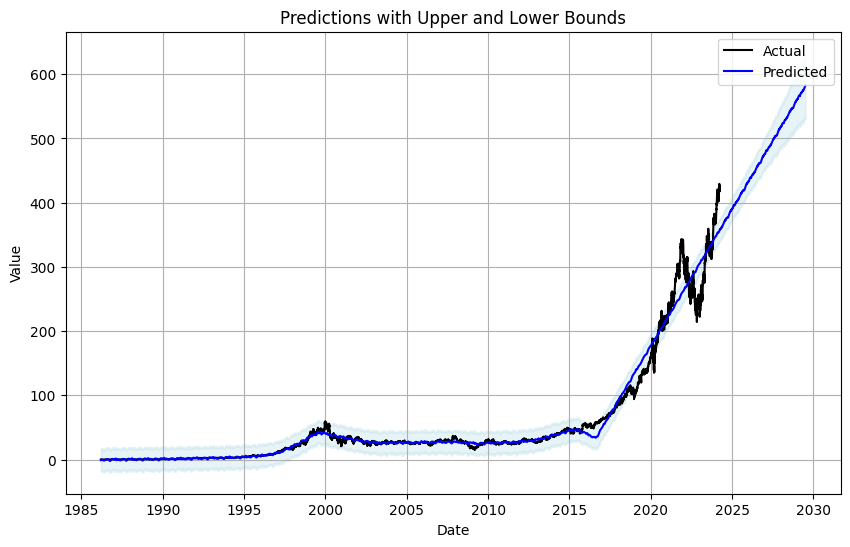

In [ ]:
plot_predictions('MSFT')